# Forecasting Crop Yields on a national scale (FACYnation) Adapted for simfarm data

### by Raphael Shirley (University of Sussex)

In this project we are using 30 years of crop yield data from various countries along with month resolution temperature and precipitation measurements to investigate a probabilistic model for predicting yields given the previous year's temperature and precipitation history.

## Step 1. Exploration of data and implementation of Bayesian version of current model

In the first notebook [Exploratory_analysis.ipynb](Exploratory_analysis.ipynb) Peter Hurley (DataJavelin) investigated the data that we have and how it can be manipulated using standard Python packages.

In the second notebook [Bayesian_MSM.ipynb](Bayesian_MSM.ipynb) Peter went on to implement a Bayesian inference version of the original model written by Ed Pope. This was done for only one of temperature and precipitation.

The original model assumes that there is some yield response function such that the total yield anomaly in year $j$ is $\Delta Y_j$, where the yield anomaly is the difference between year $j$ yield and the five year median $\widetilde{Y}_j(Y_{j-2},Y_{j-1},Y_{j},Y_{j+1},Y_{j+2} )$.

We then assume that this yield anomaly is related to a per month yield response function, $\dot{y}_i$, for each month $i$ by summation:

$$
\Delta Y_j = \sum_{i=1}^{12} \dot{y}_i
$$

Where the yield response function is some function of the monthly temperature anomaly $\Delta T_i$ and precipitation anomaly $\Delta P_i$ where both of which are the difference of the month $i$ measurement to the 30 year mean for that month. 

$$
\begin{align}
\dot{y}_i &= f(T_i, P_i) \\
& = s_t(\Delta T_i) + s_p(\Delta P_i)
\end{align}
$$

This assumes that the function is slowly changing on the scale of the temperature and precipitation anomalies such that a Taylor expansion to first order is sufficient. The previous notebook implemented this model for T only assuming that T and P are not correlated.






## Step 2. Implement Bayesian model to T and P simultaneously

Now lets implement the simple linear model but for temperature and precipitation simulataneously. We will begin with the same simple priors. The Liklihood will then be:

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan
%matplotlib inline

In [2]:
# Compile model
sm=pystan.StanModel(file='./stan/BMSM-2d.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a0b17ba4c1397a6a38934128c82562d NOW.
C:\Users\Andrew\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\AppData\Local\Temp\tmp_6ltvumk\stanfit4anon_model_0a0b17ba4c1397a6a38934128c82562d_6993135463367801340.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [3]:
data={
    'n_regions':1,
    'n_years':8,
    'd_temp':np.load('data/TempAnom.npy').reshape(1,8,12),
    'd_precip':np.load('data/RainAnom.npy').reshape(1,8,12),
    'd_yields':np.load('data/YieldAnom.npy')[0:8].reshape(1,8)
}

In [31]:
fit=sm.sampling(data=data,chains=5,iter=1000,verbose=True,control={'max_treedepth': 13})

In [32]:
fit

Inference for Stan model: anon_model_0a0b17ba4c1397a6a38934128c82562d.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[1,1]         -2.07    9.05  99.45 -194.1 -70.12   2.43  66.27 186.61    121   1.04
s_temp[1,2]          -9.8    8.33 108.39 -220.7 -82.11  -7.88  64.77 193.54    169   1.03
s_temp[1,3]          9.09   11.53 105.55 -179.9 -61.32  -0.75  70.96 258.79     84   1.08
s_temp[1,4]         -4.36    8.83 102.49 -210.9 -73.56  -4.36  65.19 198.87    135   1.03
s_temp[1,5]        -16.13    9.66  100.0 -214.9 -81.73 -11.97  47.32  182.8    107   1.05
s_temp[1,6]          5.87    7.12  85.23 -162.5 -52.04    7.3   65.7 172.38    143   1.04
s_temp[1,7]        -16.46   12.33  107.0 -216.0 -90.09  -20.4   55.0 194.01     75   1.04
s_temp[1,8]         -3.11   10.87 102.48 -215.9 -67.01   2.54  64.48 190.28     89    1.1
s_t

In [33]:
samples=fit.extract()

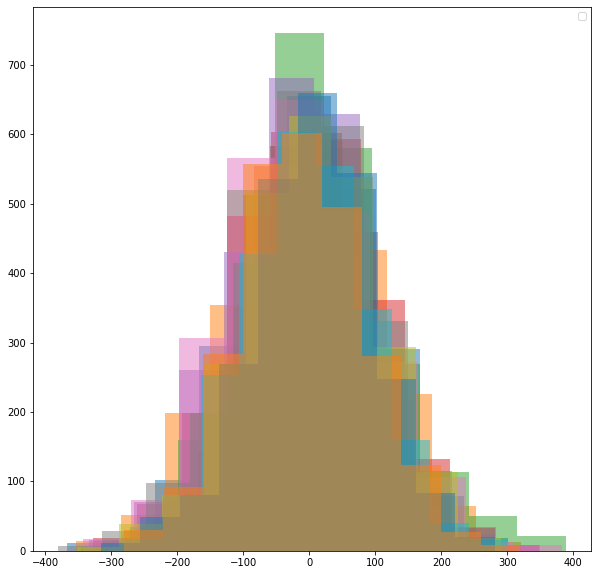

In [34]:
plt.figure(figsize=(10,10))
for i in range(0,12):
    plt.hist(samples['s_temp'][:,0,i], alpha=0.5)
plt.legend()

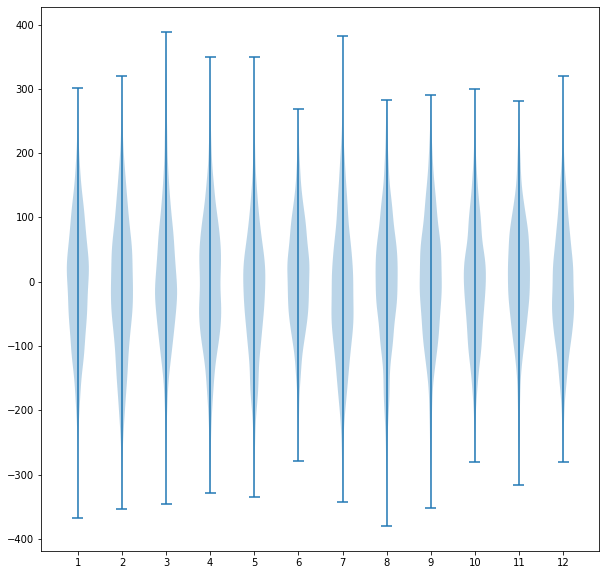

In [35]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_temp'][:,0,:]);
plt.xticks(range(1,13));

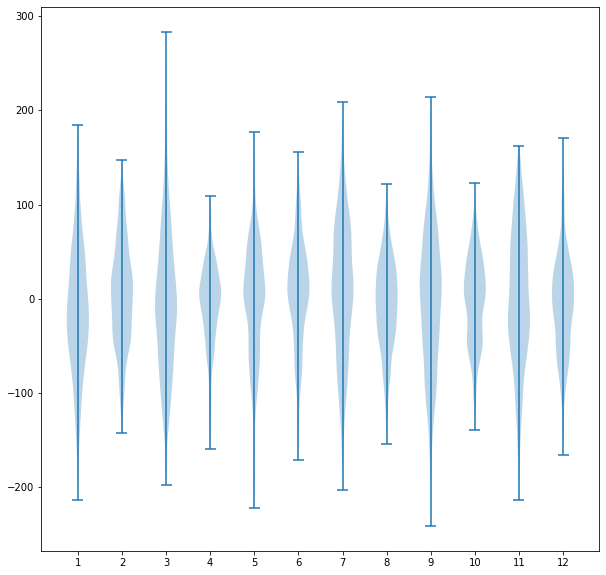

In [36]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_precip'][:,0,:]);
plt.xticks(range(1,13));

## Step 3. Implement Bayesian model where predicted yield response is 2D Gaussian of T and P 

We are assuming that for a given month there is some optimum temperature and pressure and that the yield response is some function with a broad peak. Lts try to implement a 2D Gaussian. Crucially our data for a given year does not well cover the T, P plane about the peak of the Gaussian.

The k data points are 

$$
X_k = (Y_k, \boldsymbol T_k, \boldsymbol P_k)
$$

Where $\boldsymbol T_k$ and $\boldsymbol P_k$ are vectors with values for each month of the year. Under this model the monthly yield response will be 

$$
\begin{align}
\dot{y}(T,P)
& = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\end{align}
$$

where

$$
\mu = [\mu_T,\mu_P]
$$

and

$$
\boldsymbol\Sigma =   \left[ {\begin{array}{cc}
   \Sigma_{TT} & \Sigma_{TP} \\
   \Sigma_{TP} & \Sigma_{PP} \\
  \end{array} } \right]
$$

or

$$
    \boldsymbol\Sigma = \left[ {\begin{array}{cc}
    \sigma_T^2 & \rho \sigma_T \sigma_P \\
    \rho \sigma_T \sigma_P  & \sigma_P^2 \\
    \end{array} } \right]
$$

Using the latter notation the function is

$$
\dot{y}_i ( T_i , P_i) = \frac{1}{2 \pi  \sigma_{T_i} \sigma_{P_i} \sqrt{1-\rho^2}}  \exp \left(  -\frac{1}{2(1-\rho^2)}\left[  \frac{(T_i-\mu_{T_i})^2}{\sigma_{T_i}^2} +  \frac{({P_i}-\mu_{P_i})^2}{\sigma_{P_i}^2} - \frac{2\rho({T_i}-\mu_{T_i} )({P_i}-\mu_{P_i})}{\sigma_{T_i} \sigma_{P_i}}  \right]  \right)
$$

The predicted yield is then

$$
Y = \sum_1^{12} n_i \dot{y}_i
$$

where, $n_i$ is a normalisation.

The liklihood (of one data point) is the probability of the data given the model

$$
P( Y, \boldsymbol{T}, \boldsymbol{P} | M(\mu_T,\mu_P,\Sigma_{TT},\Sigma_{TP},\Sigma_{PP}))
$$

But, we are assuming that we know $\boldsymbol{T}$ and $\boldsymbol{P}$ so the probability of one yield data point is 

$$
P( Y, | M(\mu_T,\mu_P,\Sigma_{TT},\Sigma_{TP},\Sigma_{PP},  \boldsymbol{T}, \boldsymbol{P}))
$$

In which case our liklihood is 

$$
\textrm{ln} \mathcal{L} = \sum_k \textrm{ln} N(Y - \sum_i n_i \dot{y}_i, \sigma )
$$


This model is in danger of having too many dummy parameters. Options for dealing with this are to assume the same shape for each month. This would be in agreement with a simple model that plants don't grow in winter because the temperature and precipitation conditions are not ideal. this would reduce the parameters by a factor of twelve. Another option is to fuly ignore some months since we know May to August seems to have the greatest effect on yields.

# First two dimensional model

In this example we implement the model described in detail above. We anticipate that moving forward we may want to limit the months and possibly enforce a similar shape across multiple regions or months.

In [10]:
gm = pystan.StanModel(file='./stan/BMSM-gaussian.stan') 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d40386386dfa9e1b39dbbc5dbb5c952 NOW.
C:\Users\Andrew\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\AppData\Local\Temp\tmpxwefybcr\stanfit4anon_model_6d40386386dfa9e1b39dbbc5dbb5c952_6344779412397881790.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [11]:
fit=gm.sampling(data=data, chains=4, iter=1000,  verbose=True,control={'max_treedepth': 13})

C:\Users\Andrew\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Andrew\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [12]:
fit

Inference for Stan model: anon_model_6d40386386dfa9e1b39dbbc5dbb5c952.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t[1,1]       17.9   22.78  32.23  -6.49   -4.1   2.49  42.88  73.44      2 470.64
mu_t[1,2]      -6.56    4.72   6.71  -15.6 -13.22  -5.57  -0.38   2.79      2  13.48
mu_t[1,3]       0.18    2.73   3.86  -3.97  -2.55  -1.22    3.4    6.6      2  34.07
mu_t[1,4]      -12.4   10.97  15.52 -32.34  -27.7 -12.32   2.81   7.37      2 155.51
mu_t[1,5]      -8.27    8.57  12.13 -29.19 -17.44  -2.59  -0.15   1.07      2 190.26
mu_t[1,6]        8.6     6.2   8.78  -6.58   1.55  12.23  15.17  16.04      2  79.64
mu_t[1,7]      -4.35    7.64  10.82 -22.74 -13.29   0.56   3.58   4.28      2 166.47
mu_t[1,8]      -0.14    6.19   8.77 -10.66  -7.02  -1.95    7.2  13.72      2 155.03
mu_t[1,9]       3.51    2.64   3.75  -2.37  -0.2

In [13]:
samples=fit.extract()

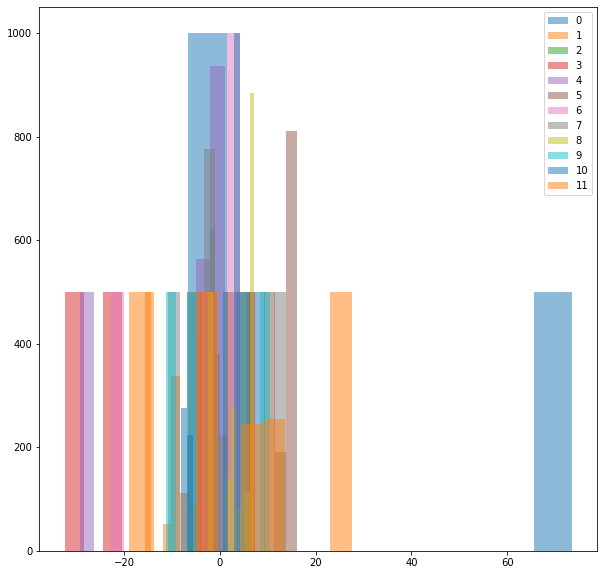

In [14]:
plt.figure(figsize=(10,10))
for i in range(0,12):
    plt.hist(samples['mu_t'][:,0,i], alpha=0.5,label=i)
plt.legend()

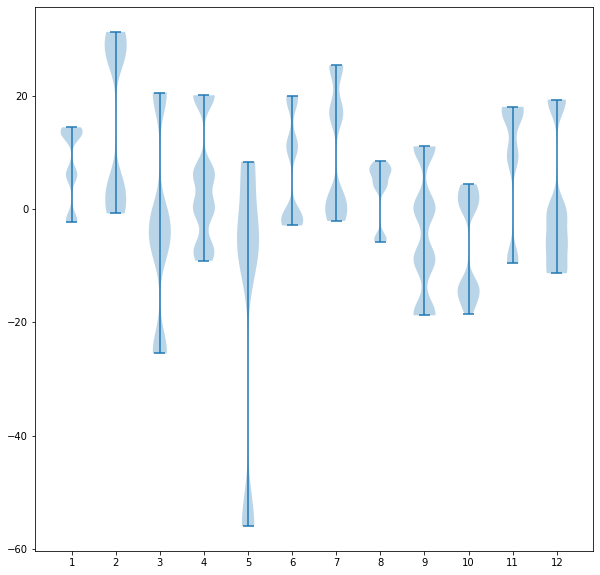

In [15]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['mu_p'][:,0,:]);
plt.xticks(range(1,13));

# Problems with this model
Clearly the model is failing. Perhaps this is due to the fact that we have far too many parameters and too little data. Lets try constraining the model to have a similar shape across months and regions as Peter did [Growth_curve_fitting.ipynb](./Growth_curve_fitting.ipynb)

## Read data

Here we copy Peter's code importing the anaomalies and converting to true temperatures and precipitation. the model fitting per mpnth doesn't require these but moving to a multi region fit does.

In [16]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [17]:
templists,rainlists,yieldlist =[],[],[]

for counter in range(1,7):
    templists.append(np.load('data/Temps'+str(counter)+'.npy'))
    
for counter in range(1,7):
    rainlists.append(np.load('data/Rain'+str(counter)+'.npy'))

for counter in range(1,7):
    yieldlist.append(np.load('data/Yield'+str(counter)+'.npy'))
    
rainlists = np.array(rainlists)
templists = np.array(templists)
yieldlist= np.array(yieldlist)

templists = templists.reshape(6,int(len(templists[0])/12),12)

templists= templists[:,:,4:10]

rainlists = rainlists.reshape(6,int(len(rainlists[0])/12),12)
rainlists= rainlists[:,:,4:10]

data2={
    'n_regions':6,
    'n_years':8,
    'd_temp':templists,
    'd_precip':rainlists,
    'd_yields':yieldlist,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)
}
            

In [18]:
#gm2 = pystan.StanModel(file='./stan/2d-gaussian.stan')

gm2 = pystan.StanModel(file='./stan/2d-gaussian_with_correlation.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2df05908660c977a9152ef2888fc2e93 NOW.
C:\Users\Andrew\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\AppData\Local\Temp\tmpplhsqya8\stanfit4anon_model_2df05908660c977a9152ef2888fc2e93_8148036073794935237.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [19]:
fit=gm2.sampling(data=data2,chains=4,iter=1000,verbose=True,seed=1308)

In [20]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2df05908660c977a9152ef2888fc2e93.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t              14.98    0.02   0.57  14.05  14.58  14.92  15.29  16.26   1182    1.0
sigma_t            5.54    0.02   0.73   4.26    5.0   5.49   6.01   7.08    944    1.0
mu_p              72.55    0.11   3.92  65.18  69.97  72.49  75.09  80.49   1251    1.0
sigma_p           49.62    0.07   2.66   44.7  47.78  49.57  51.38  55.06   1267   1.01
rho               -0.18  3.0e-3   0.12   -0.4  -0.26  -0.18   -0.1   0.05   1463    1.0
norm               2.58  3.7e-3   0.11   2.38   2.51   2.57   2.65   2.82    843   1.01
fdy1[1]            0.07  1.5e-3   0.05 6.7e-3   0.03   0.05   0.09   0.19   1044    1.0
fdy1[2]             0.1  2.0e-3   0.06   0.01   0.05   0.09   0.13   

In [21]:
# carry out some diagnostic checks on fit
import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [22]:
samples=fit.extract()

Text(0, 0.5, '$dy$')

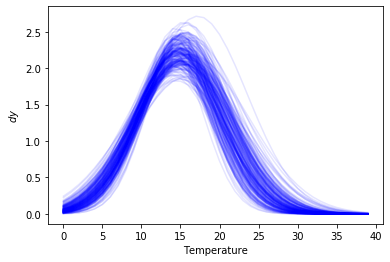

In [23]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy1'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')

Text(0, 0.5, '$dy$')

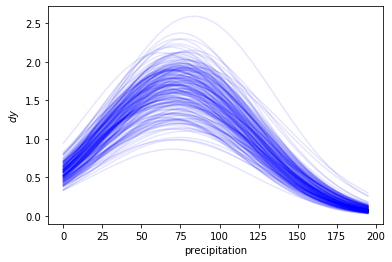

In [24]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['precip'],samples['fdy2'][i,:],alpha=0.1, c='b')
plt.xlabel('precipitation')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')

C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


AttributeError: 'PairGrid' object has no attribute 'get_figure'

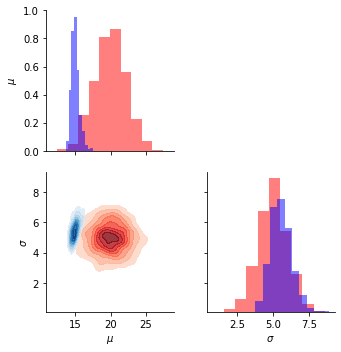

In [25]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),np.array([[5.0,0.0],[0.0,1.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,size=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu_t'],samples['sigma_t'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()

fig = g.get_figure()
fig.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.png")
fig.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.pdf")

In [ ]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([100,25]),np.array([[25.0,0.0],[0.0,5.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,size=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu_p'],samples['sigma_p'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()

fig = g.get_figure()
fig.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.png")
fig.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.pdf")